**Objective**

Our ojective is to build a model to determine if a building will have an insurance claim during a specific period using building characteristics. In this notebook we shall explore and apply four machine learning algorithms: Support Vector Machine (SVM), Linear Regression, k-nearest Neighbors (KNN), and Naive Bayes. We aslo use  Area Under the Curve (AUC) as the evaluation metric.

In [119]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Insurance/train_data.csv')
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [5]:
variable_description = pd.DataFrame({
    'Variable': ['Customer Id','YearOfObservation', 'Insured_Period	','Residential', 'Building_Painted', 'Building_Fenced','Garden', 'Settlement','Building Dimension', 'Building_Type','Date_of_Occupancy','NumberOfWindows', 'Geo Code', 'Claim' ],
   'Description': ['Identification number for the Policy holder', 'year of observation for the insured policy', 'duration of insurance policy in Olusola Insurance. (Ex: Full year insurance, Policy Duration = 1; 6 months = 0.5', 'is the building a residential building or not', 'is the building painted or not (N-Painted, V-Not Painted)', 'is the building fence or not (N-Fenced, V-Not Fenced)', 'building has garden or not (V-has garden; O-no garden)', 'Area where the building is located. (R- rural area; U- urban area)', 'Size of the insured building in m2', 'The type of building (Type 1, 2, 3, 4)', 'date building was first occupied', 'number of windows in the building', 'Geographical Code of the Insured building', 'target variable. (0: no claim, 1: at least one claim over insured period)']})
variable_description

,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period\t,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


In [6]:
df.shape

(7160, 14)

In [7]:
df.nunique()

Customer Id           7160
YearOfObservation        5
Insured_Period         401
Residential              2
Building_Painted         2
Building_Fenced          2
Garden                   2
Settlement               2
Building Dimension    2043
Building_Type            4
Date_of_Occupancy      134
NumberOfWindows         11
Geo_Code              1307
Claim                    2
dtype: int64

In [8]:
df.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [9]:
df.describe(include='O').T

,count,unique,top,freq
Customer Id,7160,7160,H14663,1
Building_Painted,7160,2,V,5382
Building_Fenced,7160,2,N,3608
Garden,7153,2,O,3602
Settlement,7160,2,R,3610
NumberOfWindows,7160,11,.,3551
Geo_Code,7058,1307,6088,143


The train dataset has 7160 rows and 14 columns

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


In [11]:
df.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [12]:
df.isnull().sum().sum()

723

We have a total of 723 missing values in the dataset

In [13]:
df.NumberOfWindows.value_counts()

   .    3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: NumberOfWindows, dtype: int64

In [14]:
df['Geo_Code'].value_counts()

6088     143
33063    137
6083     113
13206     98
31555     87
        ... 
59650      1
59656      1
60057      1
60172      1
2B353      1
Name: Geo_Code, Length: 1307, dtype: int64

In [15]:
df['Geo_Code'] = df['Geo_Code'].fillna(df['Geo_Code'].mode()[0])

In [16]:
df['Garden'] = df['Garden'].fillna(df['Garden'].mode()[0])

In [17]:
#Distribution of data is skewed hence we use median
df['Date_of_Occupancy'] = df['Date_of_Occupancy'].fillna(df['Date_of_Occupancy'].median())

In [18]:
#Distribution of data is skewed hence we use median
df['Building Dimension'] = df['Building Dimension'].fillna(df['Building Dimension'].median())

In [19]:
df.drop(columns=['NumberOfWindows','Customer Id'],inplace=True)

The column NumberOfWindows contain a high number of special characters(.) which have no meaning and dont add value to the model hence we shall drop this column

In [20]:
df.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code,Claim
0,2013,1.0,0,N,V,V,U,290.0,1,1960.0,1053,0
1,2015,1.0,0,V,N,O,R,490.0,1,1850.0,1053,0
2,2014,1.0,0,N,V,V,U,595.0,1,1960.0,1053,0
3,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,1053,0
4,2014,1.0,0,V,N,O,R,680.0,1,1800.0,1053,0


In [21]:
df.isnull().sum()

YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
Geo_Code              0
Claim                 0
dtype: int64

In [22]:
df.shape

(7160, 12)

In [23]:
duplicates = df.duplicated().sum()
print(f'Duplicates in dataset are {duplicates}')

Duplicates in dataset are 13


In [24]:
df['Building_Painted'].value_counts()

V    5382
N    1778
Name: Building_Painted, dtype: int64

In [25]:
df['Building_Type'].value_counts()

2    3305
1    1716
3    1230
4     909
Name: Building_Type, dtype: int64

**Visualization**

Distribution of Categorical data

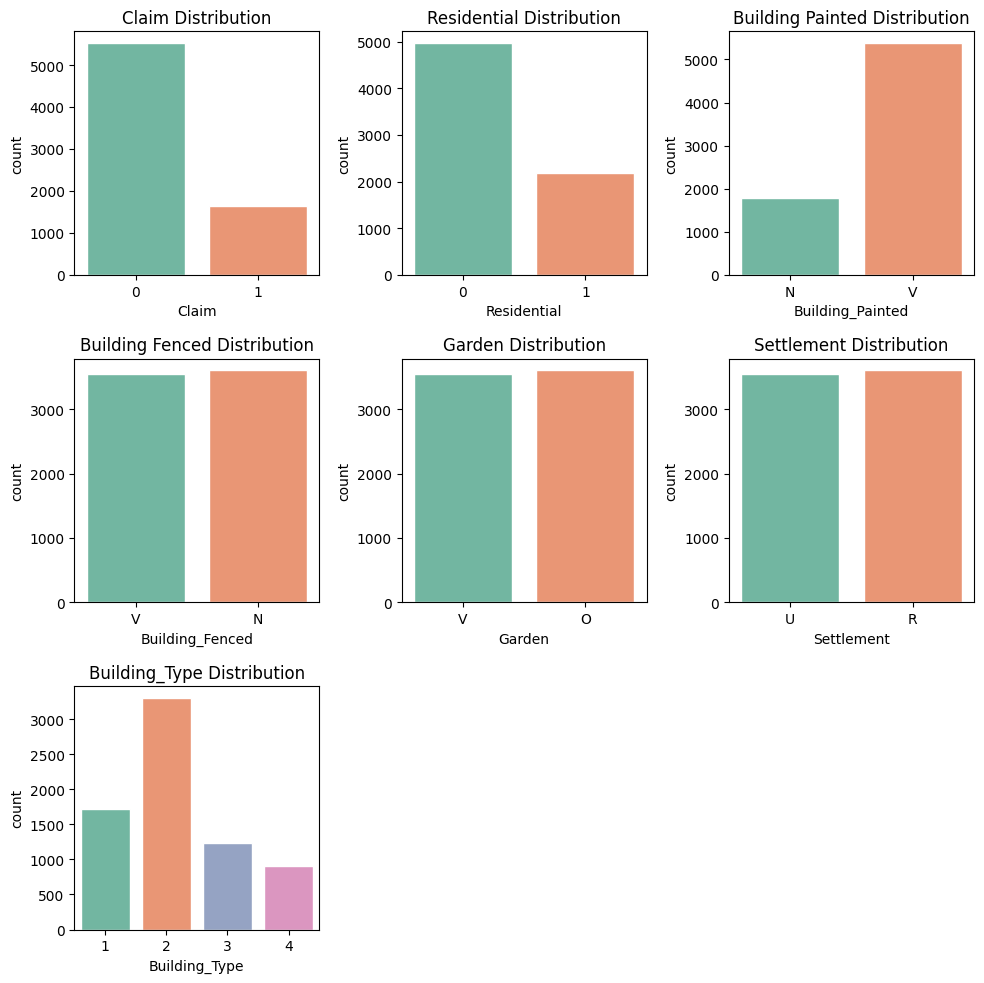

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
sns.set_theme(style="darkgrid")
# Plot the Claim distribution
sns.countplot(data=df, x='Claim', ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Claim Distribution')

# Plot the Residential distribution
sns.countplot(data=df, x='Residential', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Residential Distribution')


# Plot the Building Painted distribution
sns.countplot(data=df, x='Building_Painted', ax=axes[0, 2], palette='Set2')
axes[0, 2].set_title('Building Painted Distribution')

# Plot the Building Fenced distribution
sns.countplot(data=df, x='Building_Fenced', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Building Fenced Distribution')

#Plot the Garden distribution
sns.countplot(data=df, x='Garden', ax=axes[1, 1],palette='Set2')
axes[1, 1].set_title('Garden Distribution')

# Plot the Settlement distribution
sns.countplot(data=df, x='Settlement', ax=axes[1, 2],palette='Set2')
axes[1, 2].set_title('Settlement Distribution')

#Plot the Building_Type distribution
sns.countplot(data=df, x='Building_Type', ax=axes[2, 0],palette='Set2')
axes[2, 0].set_title('Building_Type Distribution')


#Plot the Insured_Period distribution
#sns.countplot(data=df, x='Insured_Period', ax=axes[2, 1],palette='Set3')
#axes[2, 1].set_title('Insured_Period Distribution')

#Plot the Building_Type distribution
#sns.countplot(data=df, x='Building_Type', ax=axes[2, 1],palette='Set3')
#axes[2, 1].set_title('Building_Type Distribution')

fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


**Distribution of continuous variables**

In [27]:
numerical_cont =['Building Dimension', 'Date_of_Occupancy']

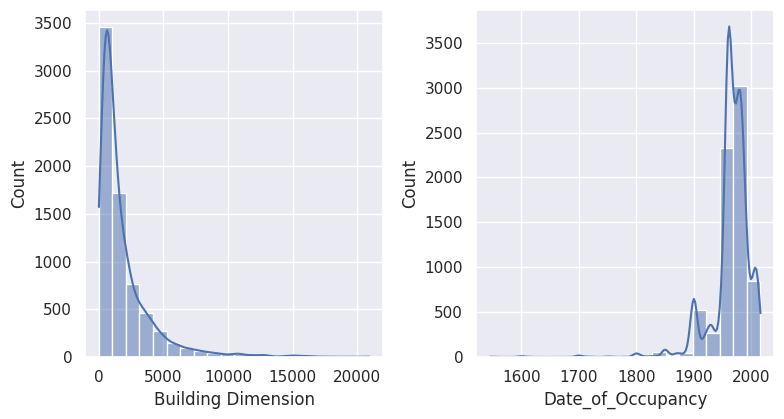

In [28]:
plt.figure(figsize=(8, 8))
for i, column in enumerate(numerical_cont, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[column], bins=20, kde = True)
plt.tight_layout()
plt.show()


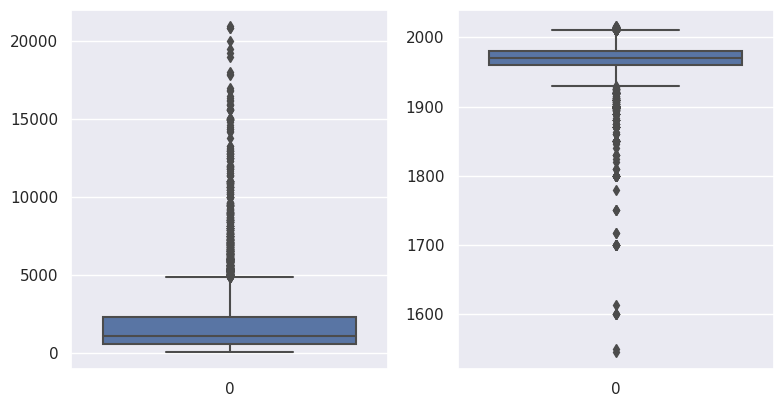

In [29]:
plt.figure(figsize=(8, 8))
for i, column in enumerate(numerical_cont, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(df[column])
plt.tight_layout()
plt.show()

**Relationship between categorical variables and Claim**

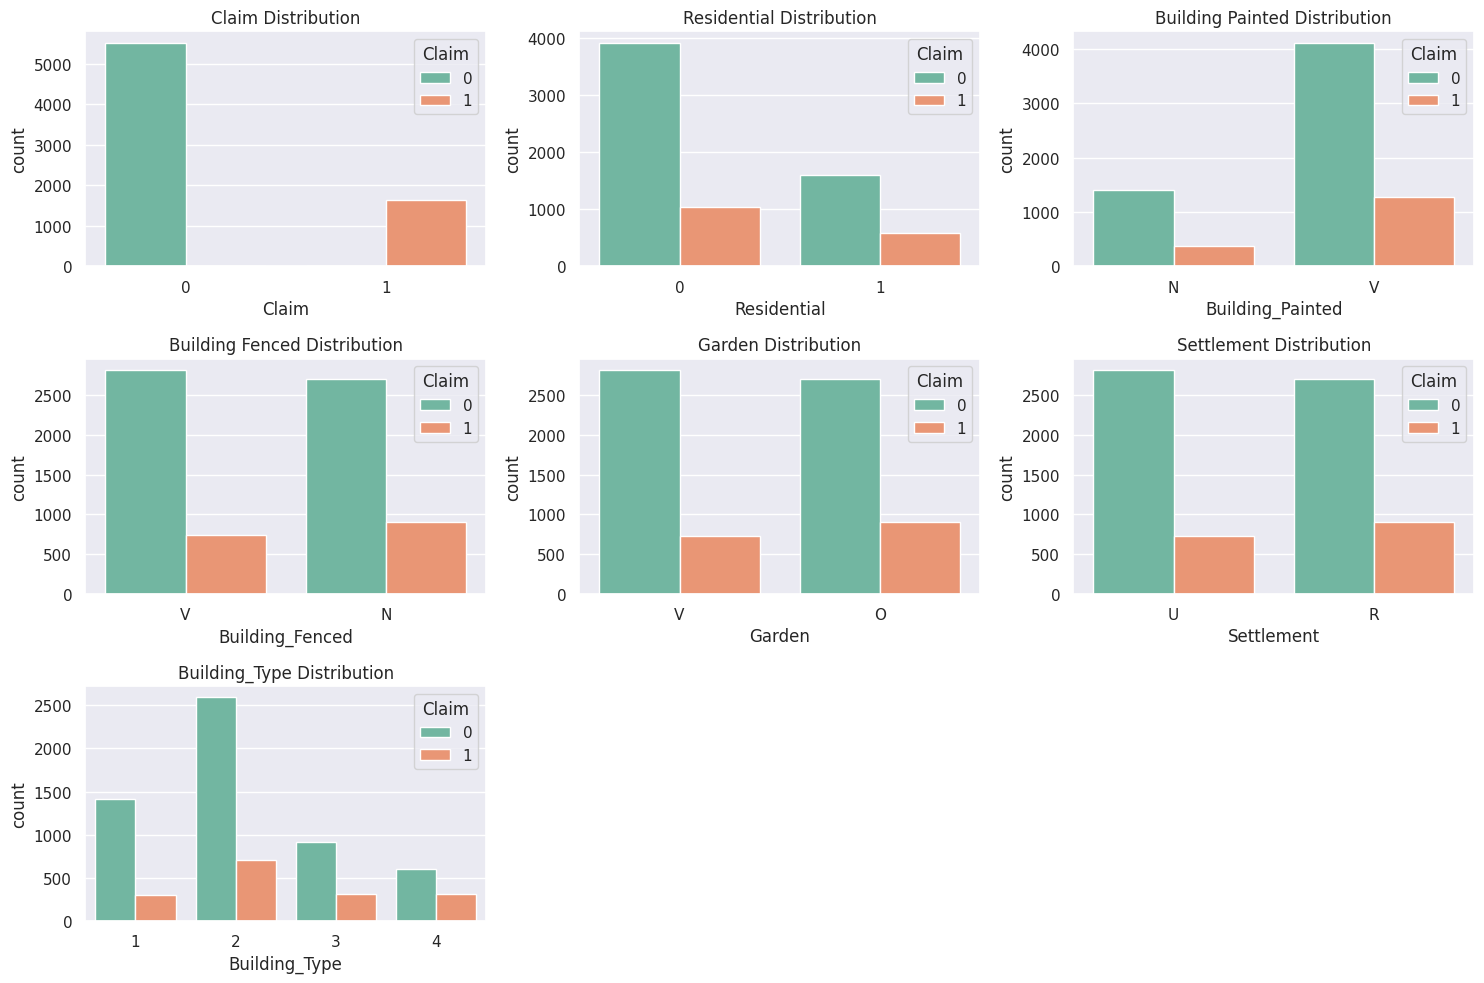

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
sns.set_theme(style="darkgrid")
# Plot the Claim distribution
sns.countplot(data=df, x='Claim', ax=axes[0, 0], hue = 'Claim', palette='Set2')
axes[0, 0].set_title('Claim Distribution')

# Plot the Residential distribution
sns.countplot(data=df, x='Residential', ax=axes[0, 1], hue = 'Claim',palette='Set2')
axes[0, 1].set_title('Residential Distribution')


# Plot the Building Painted distribution
sns.countplot(data=df, x='Building_Painted', ax=axes[0, 2], hue = 'Claim',palette='Set2')
axes[0, 2].set_title('Building Painted Distribution')

# Plot the Building Fenced distribution
sns.countplot(data=df, x='Building_Fenced', ax=axes[1, 0], hue = 'Claim',palette='Set2')
axes[1, 0].set_title('Building Fenced Distribution')

#Plot the Garden distribution
sns.countplot(data=df, x='Garden', ax=axes[1, 1], hue = 'Claim',palette='Set2')
axes[1, 1].set_title('Garden Distribution')

# Plot the Settlement distribution
sns.countplot(data=df, x='Settlement', ax=axes[1, 2], hue = 'Claim',palette='Set2')
axes[1, 2].set_title('Settlement Distribution')

#Plot the Building_Type distribution
sns.countplot(data=df, x='Building_Type', ax=axes[2, 0], hue = 'Claim',palette='Set2')
axes[2, 0].set_title('Building_Type Distribution')


#Plot the Insured_Period distribution
#sns.countplot(data=df, x='Insured_Period', ax=axes[2, 1],palette='Set3')
#axes[2, 1].set_title('Insured_Period Distribution')


fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [31]:
numerical_cont

['Building Dimension', 'Date_of_Occupancy']

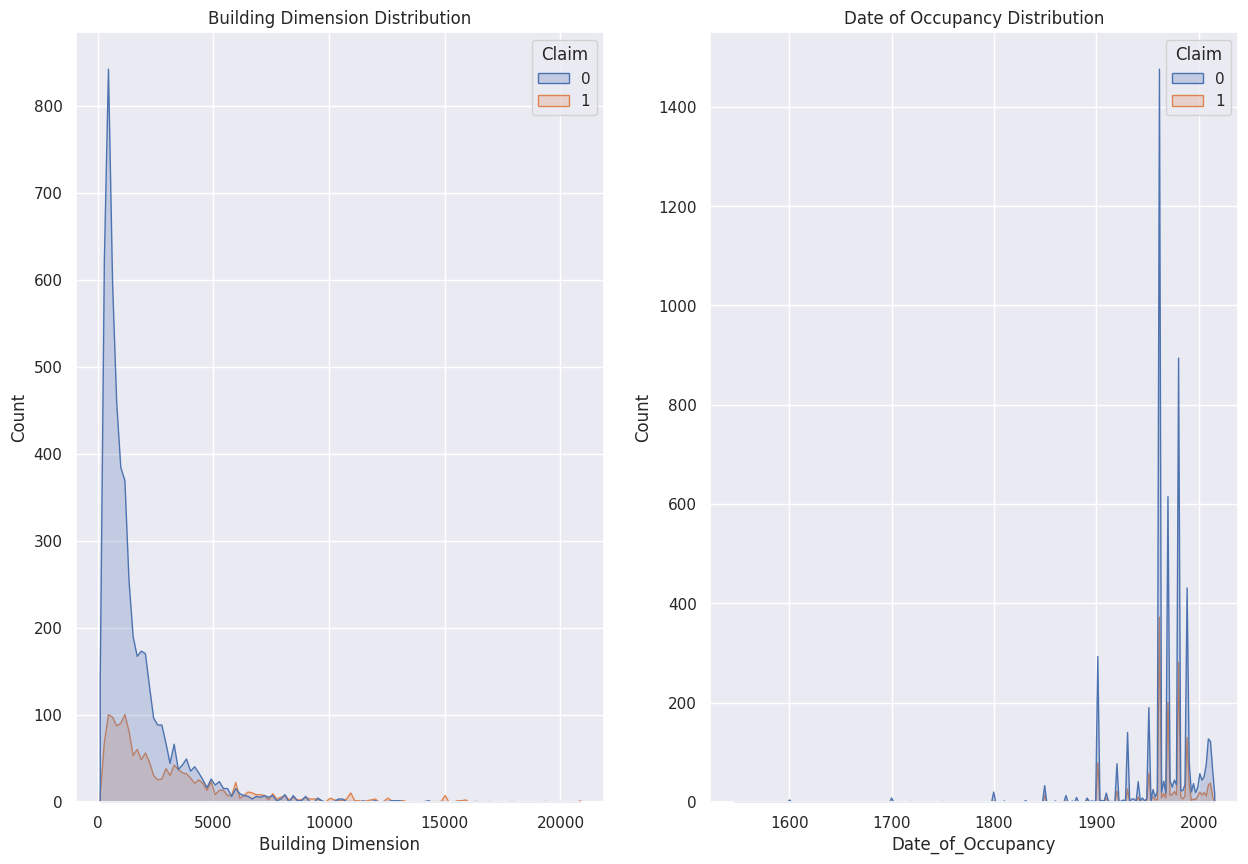

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
sns.set_theme(style="darkgrid")
sns.histplot(df, x="Building Dimension", hue="Claim", element="poly", ax=axes[0])

axes[0].set_title("Building Dimension Distribution")

sns.histplot(df, x="Date_of_Occupancy", hue="Claim", element="poly", ax=axes[1])
axes[1].set_title("Date of Occupancy Distribution")

plt.show()


In [33]:
df['Building_Painted'] = df['Building_Painted'].replace({'V':0, 'N':1})

df['Building_Fenced']= df['Building_Fenced'].replace({'V':0, 'N':1})

df['Garden']= df['Garden'].replace({'O':0, 'V':1})

df['Settlement']= df['Settlement'].replace({'R':0, 'U':1})

df['Building_Type']= df['Building_Type'].replace({'1':0, '2':1, '3':2, '4':3})

In [34]:
# Removing outliers for 'Building Dimensions'
low, high = df['Building Dimension'].quantile([0.1, 0.9])
mask_date = df['Building Dimension'].between(low, high)
df = df[mask_date]

In [35]:
#Removing outliers for 'Date_of_Occupacy'
low, high = df['Date_of_Occupancy'].quantile([0.1,0.9])
mask_date = df['Date_of_Occupancy'].between(low, high)
df= df[mask_date]

In [36]:
df.describe()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000
mean,2013.666453,0.911699,0.293641,0.305805,0.393086,0.606701,0.606487,1389.158344,2.199744,1967.946223,0.209347
std,1.384444,0.240086,0.455478,0.460797,0.488488,0.488534,0.488581,982.316709,0.938338,15.541266,0.406886
min,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,330.000000,1.000000,1920.000000,0.000000
25%,2012.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,600.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1900.000000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4300.000000,4.000000,1999.000000,1.000000


**Feature Selection**

In [37]:
df_train = df.drop(df[df.Geo_Code.str.contains(r'[A-Z]')].index)

In [38]:
df_train['Geo_Code'] = pd.to_numeric(df_train['Geo_Code'])

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4649 entries, 2 to 7158
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   4649 non-null   int64  
 1   Insured_Period      4649 non-null   float64
 2   Residential         4649 non-null   int64  
 3   Building_Painted    4649 non-null   int64  
 4   Building_Fenced     4649 non-null   int64  
 5   Garden              4649 non-null   int64  
 6   Settlement          4649 non-null   int64  
 7   Building Dimension  4649 non-null   float64
 8   Building_Type       4649 non-null   int64  
 9   Date_of_Occupancy   4649 non-null   float64
 10  Geo_Code            4649 non-null   int64  
 11  Claim               4649 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 472.2 KB


In [40]:
#Getting the target feature(attribution) and storing it in a, and the rest of the features in b
a = df_train.drop(columns=['Claim'])  # Features
b = df_train['Claim']  # Target variable

In [41]:
#Feature selection using chi-squared statistics and ANOVA F-statistic
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Calculate chi-squared statistics for each feature
chi2_scores = chi2(a, b)[0]

# Calculate ANOVA F-statistic and p-values for each feature
f_scores = f_classif(a, b)[0]

# Combine chi-squared and ANOVA scores
combined_scores = chi2_scores + f_scores

feature_scores = pd.DataFrame({'Feature': a.columns, 'Combined_Score': combined_scores})
feature_scores = feature_scores.sort_values(by='Combined_Score', ascending=False)
feature_scores

,Feature,Combined_Score
7,Building Dimension,149991.982652
10,Geo_Code,59530.926563
8,Building_Type,89.708312
1,Insured_Period,32.023388
2,Residential,29.516505
4,Building_Fenced,5.914192
5,Garden,5.425657
6,Settlement,5.340844
3,Building_Painted,0.880607
0,YearOfObservation,0.868747


In [42]:
feature_scores

,Feature,Combined_Score
7,Building Dimension,149991.982652
10,Geo_Code,59530.926563
8,Building_Type,89.708312
1,Insured_Period,32.023388
2,Residential,29.516505
4,Building_Fenced,5.914192
5,Garden,5.425657
6,Settlement,5.340844
3,Building_Painted,0.880607
0,YearOfObservation,0.868747


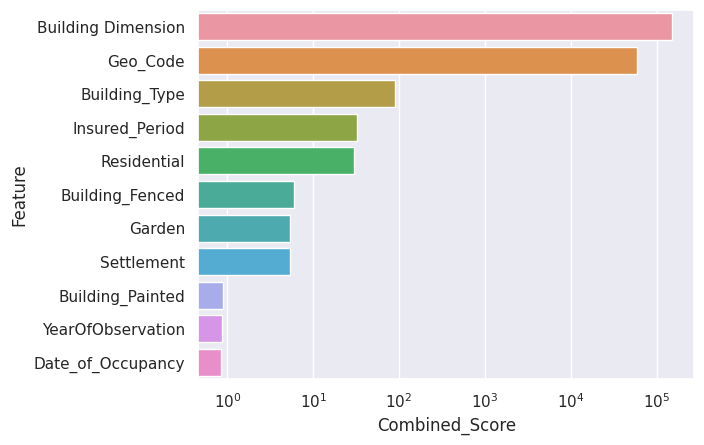

In [43]:
sns.barplot(feature_scores, y ='Feature', x ='Combined_Score')
plt.xscale('log')

**Importing test Data**

In [44]:
df_test = pd.read_csv('/content/drive/MyDrive/Datasets/Insurance/test_data.csv')
df_test.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321


In [45]:
df_test.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  4
Settlement              0
Building Dimension     13
Building_Type           0
Date_of_Occupancy     728
NumberOfWindows         0
Geo_Code               13
dtype: int64

In [46]:
df_test['Geo_Code'] = df_test['Geo_Code'].fillna(df['Geo_Code'].mode()[0])

In [47]:
df_test['Garden']= df_test['Garden'].fillna(df['Garden'].mode()[0])

In [48]:
#Distribution of data is skewed hence we use median
df_test['Building Dimension'] = df_test['Building Dimension'].fillna(df['Building Dimension'].median())

In [49]:
df_test.drop(columns=['NumberOfWindows'],inplace=True)

In [50]:
df_test['Date_of_Occupancy'] = df_test['Date_of_Occupancy'].fillna(df['Date_of_Occupancy'].median())

In [51]:
df_test.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3321


In [52]:
df_test_new = df_test.copy()
df_test_new.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3321


In [53]:
df_test.drop(columns=['Customer Id'], inplace = True)

In [54]:
df_test.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code
0,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3310
1,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3310
2,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,3310
3,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3321
4,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3321


In [55]:
df_test['Building_Painted'] = df_test['Building_Painted'].replace({'V':0, 'N':1})

df_test['Building_Fenced']= df_test['Building_Fenced'].replace({'V':0, 'N':1})

df_test['Garden']= df_test['Garden'].replace({'O':0, 'V':1})

df_test['Settlement']= df_test['Settlement'].replace({'R':0, 'U':1})

df_test['Building_Type']= df_test['Building_Type'].replace({'1':0, '2':1, '3':2, '4':3})

In [56]:
df_test.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code
0,2013,1.000000,0,0,1,0,0,300.0,1,1960.0,3310
1,2016,0.997268,0,0,1,0,0,300.0,1,1960.0,3310
2,2013,0.369863,0,0,0,1,1,790.0,1,1960.0,3310
3,2014,1.000000,0,0,1,0,0,1405.0,1,2004.0,3321
4,2016,1.000000,0,0,1,0,0,1405.0,1,2004.0,3321


In [57]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   3069 non-null   int64  
 1   Insured_Period      3069 non-null   float64
 2   Residential         3069 non-null   int64  
 3   Building_Painted    3069 non-null   int64  
 4   Building_Fenced     3069 non-null   int64  
 5   Garden              3069 non-null   int64  
 6   Settlement          3069 non-null   int64  
 7   Building Dimension  3069 non-null   float64
 8   Building_Type       3069 non-null   int64  
 9   Date_of_Occupancy   3069 non-null   float64
 10  Geo_Code            3069 non-null   object 
dtypes: float64(3), int64(7), object(1)
memory usage: 263.9+ KB


In [58]:
df_test = df_test.drop(df_test[df_test.Geo_Code.str.contains(r'[A-Z]')].index)
df_test['Geo_Code'] = pd.to_numeric(df_test['Geo_Code'])

In [59]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2929 entries, 0 to 3068
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   2929 non-null   int64  
 1   Insured_Period      2929 non-null   float64
 2   Residential         2929 non-null   int64  
 3   Building_Painted    2929 non-null   int64  
 4   Building_Fenced     2929 non-null   int64  
 5   Garden              2929 non-null   int64  
 6   Settlement          2929 non-null   int64  
 7   Building Dimension  2929 non-null   float64
 8   Building_Type       2929 non-null   int64  
 9   Date_of_Occupancy   2929 non-null   float64
 10  Geo_Code            2929 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 274.6 KB


In [60]:
X_test = df_test.copy()

In [61]:
X_test.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code
0,2013,1.000000,0,0,1,0,0,300.0,1,1960.0,3310
1,2016,0.997268,0,0,1,0,0,300.0,1,1960.0,3310
2,2013,0.369863,0,0,0,1,1,790.0,1,1960.0,3310
3,2014,1.000000,0,0,1,0,0,1405.0,1,2004.0,3321
4,2016,1.000000,0,0,1,0,0,1405.0,1,2004.0,3321


**Model Building**

In [62]:
x = df_train.drop(columns=['Claim'])  # Features
y = df_train['Claim']  # Target variable

In [63]:
x.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code
2,2014,1.000000,0,1,0,1,1,595.0,1,1960.0,1053
3,2013,1.000000,0,0,0,1,1,2840.0,1,1960.0,1053
5,2012,1.000000,0,0,1,0,0,535.0,1,1980.0,1143
6,2012,1.000000,0,1,0,1,1,2830.0,1,1988.0,1143
10,2013,0.241096,0,0,1,0,0,550.0,1,1960.0,1283


In [64]:
y

2       0
3       0
5       0
6       0
10      0
       ..
7151    0
7153    0
7156    1
7157    0
7158    0
Name: Claim, Length: 4649, dtype: int64

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size= 0.2, random_state =0)

In [66]:
y_train.value_counts()

0    2941
1     778
Name: Claim, dtype: int64

**Dealing with the imbalanced dataset using Smote**

In [67]:
#Before oversampling
#print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
#print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

In [68]:
# Apply SMOTE to oversample the minority class
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_resampled, y_resampled = smote.fit_resample(x, y)

# Print the class distribution after resampling
#print("Class distribution after resampling:", Counter(y_resampled))

In [69]:
#colors = ['#66b3ff', '#ff9999']
#explode = (0.05,0.05)
#plt.figure(figsize=(5, 5))
#plt.pie(pd.Series(y_resampled).value_counts(), colors = colors, labels=['No', 'Yes'],
 #       autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#plt.legend()
#plt.title("Oversampled Targets in Training Set")
#plt.show()

In [70]:
#splitting the resampled data into training and testing sets
#from sklearn.model_selection import train_test_split
#X1_train, X1_test, y1_train, y1_test = train_test_split(X_resampled, y_resampled, test_size= 0.20, random_state=0)

In [71]:
pd.set_option('display.max_columns',None)
X_train.head()


,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code
972,2014,1.0,0,0,1,0,0,900.0,2,1960.0,13201
1083,2015,1.0,0,1,0,1,1,1830.0,2,1980.0,13204
378,2013,1.0,1,0,1,0,0,1630.0,4,1970.0,6088
2927,2014,1.0,0,0,1,0,0,2000.0,2,1960.0,38516
6683,2013,1.0,1,1,0,1,1,460.0,3,1988.0,93073


In [72]:
X_train.shape

(3719, 11)

In [73]:
X_train['Building Dimension']

972      900.0
1083    1830.0
378     1630.0
2927    2000.0
6683     460.0
         ...  
1562     530.0
4960    1140.0
2528    3600.0
3959    4300.0
4133     360.0
Name: Building Dimension, Length: 3719, dtype: float64

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_standardize = ['YearOfObservation','Building Dimension', 'Date_of_Occupancy','Geo_Code']
X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])
X_val[columns_to_standardize] = scaler.transform(X_val[columns_to_standardize])

In [75]:
X_train.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Geo_Code
972,0.240579,1.0,0,0,1,0,0,-0.492333,2,-0.520190,-1.224868
1083,0.961540,1.0,0,1,0,1,1,0.459292,2,0.779718,-1.224769
378,-0.480382,1.0,1,0,1,0,0,0.254642,4,0.129764,-1.459843
2927,0.240579,1.0,0,0,1,0,0,0.633245,2,-0.520190,-0.388599
6683,-0.480382,1.0,1,1,0,1,1,-0.942564,3,1.299681,1.413666


**Building SVM**

In [113]:
from sklearn.svm import SVC
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_val)
acc_svc = (svm_classifier.score(X_train, y_train))
acc_svc

0.7921484269965045

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
cm1 = confusion_matrix(y_val, y_pred_svm)
print(cm1)
accuracy_score(y_val, y_pred_svm)
#print(classification_report(y_val, y_pred_svm))

[[733   4]
 [192   1]]


0.789247311827957

In [78]:
#metrics.roc_auc_score(y_val, y_pred_svm)

In [79]:
#Hyperparamter tuning using Gridsearch

#parameters = {"C":(0.1, 0.5, 1, 2, 5, 10, 20),
 #         "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1),
  #        "kernel":('linear', 'poly', 'rbf')}

#grid_search = GridSearchCV(estimator= svm_classifier, param_grid=parameters, scoring = 'accuracy', cv =10)

#grid_search.fit(X_train, y_train)
#best_accuracy = grid_search.best_score_
#best_parameters = grid_search.best_params_

#print('Best Accuracy: {:.2f}%' .format(best_accuracy*100))
#print('Best Parameters:', best_parameters)


In [80]:
#other option for tuning
# Tunning Params
#parameters = [
#              {'C': [1, 10, 100, 1000],
#               'kernel': ['linear']
#              },
#              {'C': [1, 10, 100, 1000],
#               'gamma': [0.001, 0.0001],
#               'kernel': ['rbf']
#              }
#]
#grid_search = GridSearchCV(estimator= svm_classifier, param_grid=parameters, scoring = 'accuracy', cv =10)

#grid_search.fit(X_train, y_train)
#best_accuracy = grid_search.best_score_
#best_parameters = grid_search.best_params_

#print('Best Accuracy: {:.2f}%' .format(best_accuracy*100))
#print('Best Parameters:', best_parameters)


In [114]:
# Creating instances (i.e. objects) of the roc curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_svm)

In [120]:
#roc_auc = auc(fpr, tpr)

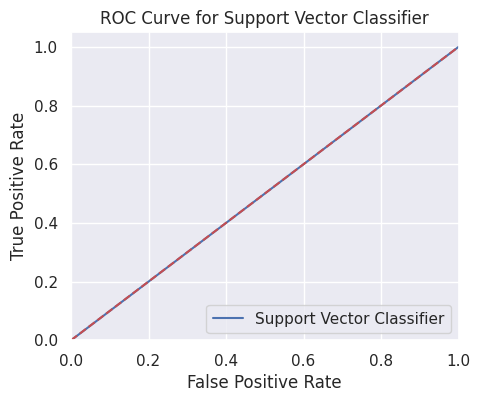

In [121]:
# Visualisation of the models's performance on an ROC/AUC curve
plt.figure(figsize=(5,4))
#y_pred_svm = svm_classifier.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_svm)
nb_roc_auc2=roc_auc_score(y_val,svm_classifier.predict(X_val))
plt.plot(fpr, tpr, label='Support Vector Classifier')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.title('ROC Curve for Support Vector Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [123]:
#fpr, tpr, thresholds = roc_curve(y_val, y_pred_svm)
#nb_roc_auc2=roc_auc_score(y_val,svm_classifier.predict(X_val))
#plt.plot(fpr, tpr, label='Support Vector Classifier')
#plt.plot([0,1],[0,1],'r--')
#plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.05])
#plt.legend(loc='lower right')
#plt.title('ROC Curve for Support Vector Classifier')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.show()

**Linear Regression Model**

In [85]:
from sklearn.linear_model import LinearRegression
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
y_pred_lin = linear_reg_model.predict(X_val)

In [86]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_val, y_pred_lin)
rmse = np.sqrt(mse)
r2= r2_score(y_val, y_pred_lin)

print(f'MSE:{(mse)}')
print(f'RMSE:{rmse}')
print(f'R2:{r2}')

MSE:0.15512549464672978
RMSE:0.39385973981447986
R2:0.05675550425013487


In [87]:
linear_reg_model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [88]:
#Perfroming crossvalidatiom
#from sklearn.model_selection import cross_val_score
#accuracies = cross_val_score(estimator= linear_reg_model, X =X_train , y= y_train, cv= 10)
#print('Accuracy: {:.2f}%' .format(accuracies.mean()*100))

In [89]:
#cm2 = confusion_matrix(y_val, y_pred_lin)
#print(cm2)
#accuracy_score(y_val, y_pred_lin)

**K-Nearest Neighbours**

In [90]:
from sklearn.neighbors import KNeighborsClassifier
KNN_classifier = KNeighborsClassifier(n_neighbors = 5)
KNN_classifier.fit(X_train, y_train)
acc_knn = (KNN_classifier.score(X_train, y_train))
acc_knn

0.8187684861521914

In [91]:
y_pred_knn = KNN_classifier.predict(X_val)
#y_predict_probaknn = KNN_classifier.predict_proba(X_val)[:,1]

In [92]:
cm3 = confusion_matrix(y_val, y_pred_knn)
print(cm3)
accuracy_score(y_val, y_pred_knn)

[[675  62]
 [159  34]]


0.7623655913978494

In [93]:
# Tunning Params
#parameters = {
#    'n_neighbors': list(range(1, 30)),
#    'leaf_size': list(range(1,30)),
#    'weights': [ 'distance', 'uniform' ]
#}
#grid_search = GridSearchCV(estimator= KNN_classifier, param_grid=parameters, scoring = 'accuracy', cv =10)

#grid_search.fit(X_train, y_train)
#best_accuracy = grid_search.best_score_
#best_parameters = grid_search.best_params_

#print('Best Accuracy: {:.2f}%' .format(best_accuracy*100))
#print('Best Parameters:', best_parameters)


In [94]:
#more params
#knnParams = {"n_neighbors":np.arange(3,9),
#              "leaf_size":[1, 2, 3, 5],
#              "weights":["uniform", "distance"],
#              "algorithm":["auto", "ball_tree","kd_tree","brute"]}

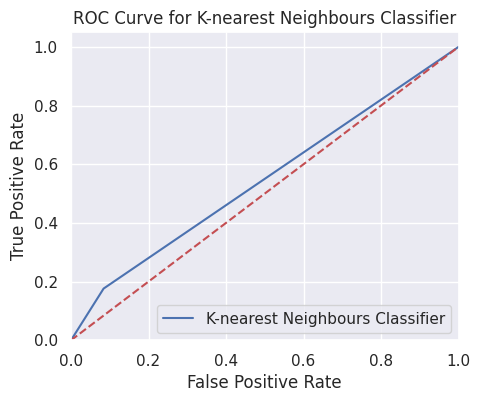

In [95]:
plt.figure(figsize=(5,4))
y_predictnb_proba = KNN_classifier.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_knn)
nb_roc_auc2=roc_auc_score(y_val, KNN_classifier.predict(X_val))
plt.plot(fpr, tpr, label='K-nearest Neighbours Classifier')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.title('ROC Curve for K-nearest Neighbours Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Naive Bayes**

In [96]:
from sklearn.naive_bayes import GaussianNB
NaiveBayes_classifier = GaussianNB()
NaiveBayes_classifier.fit(X_train, y_train)
y_pred_nb = NaiveBayes_classifier.predict(X_val)
acc_gaussian =(NaiveBayes_classifier.score(X_train, y_train))
acc_gaussian

0.777090615756924

In [97]:
metrics.roc_auc_score(y_val, y_pred_nb)

0.5766762044698786

In [98]:
cm4 = confusion_matrix(y_val, y_pred_nb)
print(cm4)
accuracy_score(y_val, y_pred_nb)

[[682  55]
 [149  44]]


0.7806451612903226

In [99]:
# Tunning Params
#parameters = {'var_smoothing': [1e-11, 1e-10, 1e-9]}

#grid_search = GridSearchCV(estimator= NaiveBayes_classifier, param_grid=parameters, scoring = 'accuracy', cv =10)

#grid_search.fit(X_train, y_train)
#best_accuracy = grid_search.best_score_
#best_parameters = grid_search.best_params_

#print('Best Accuracy: {:.2f}%' .format(best_accuracy*100))
#print('Best Parameters:', best_parameters)


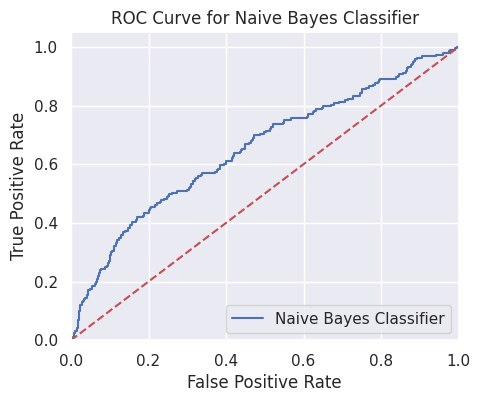

In [100]:
# Visualisation of the models's performance on an ROC/AUC curve
plt.figure(figsize=(5,4))
y_predictnb_proba = NaiveBayes_classifier.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val,  y_predictnb_proba)
nb_roc_auc2=roc_auc_score(y_val,NaiveBayes_classifier.predict(X_val))
plt.plot(fpr, tpr, label='Naive Bayes Classifier')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.title('ROC Curve for Naive Bayes Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


In [101]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines','Linear Regression', 'KNN','Naive Bayes'],
   'Score': [acc_svc,  rmse, acc_knn ,acc_gaussian]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,KNN,0.818768
0,Support Vector Machines,0.792148
3,Naive Bayes,0.777091
1,Linear Regression,0.393860


In [102]:
X_train.shape

(3719, 11)

In [103]:
X_test.shape

(2929, 11)

In [104]:
#Predicted Claim Status
predictions = KNN_classifier.predict(X_test)

In [105]:
#Convert the test data into an array
test_array = np.array(df_test)

In [106]:
#Predicted Claim Status
predicted_values = KNN_classifier.predict(test_array)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [107]:
#Convert the predicted values to an dataframe
predicted_df = pd.DataFrame(predicted_values, columns=['Claim'])

In [108]:
#Creat a dataframe for the customer id
col = ['Customer Id']
customer_id_df = df_test_new[col]

In [109]:
predicted_df_final= pd.concat([customer_id_df,predicted_df], axis=1)

In [110]:
predicted_df_final.to_csv('Predictions_Output.csv', index =False)